In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import json, os, joblib, math, ast
from itertools import product

# COMPARAÇÃO DE MODELOS

In [2]:
df = []

for path in os.listdir('Backup'):
    index = int(path.split('_')[-1])
    
    with open(f'Backup/{path}/info.json', 'r', encoding='utf-8') as file:
        data = json.loads(file.read())
    
    name = data['model']
    data = data['info']
    data['name'] = name
    data['id'] = index
    df.append(data)


df = pd.DataFrame(df)
df

,accuracy,precision,recall,auc,name,id
0,0.958923,0.959409,0.958923,0.994441,logistic_regression,2
1,0.958783,0.959367,0.958783,0.994548,logistic_regression,1


In [3]:
df = df.sort_values(by='auc', ascending=False)
df

,accuracy,precision,recall,auc,name,id
1,0.958783,0.959367,0.958783,0.994548,logistic_regression,1
0,0.958923,0.959409,0.958923,0.994441,logistic_regression,2


Text(0, 0.5, 'AUC')

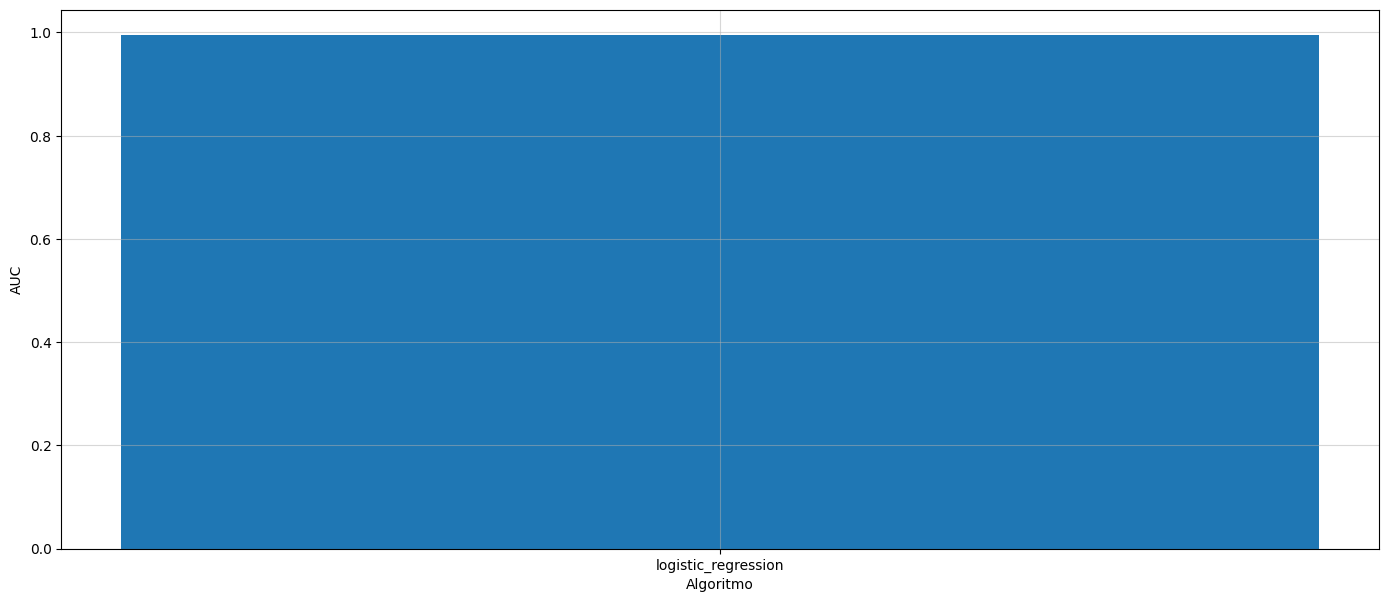

In [4]:
plt.figure(figsize=(17, 7))
plt.bar(df.name, df.auc)
plt.grid(alpha=0.5)
plt.xlabel('Algoritmo'); plt.ylabel('AUC')

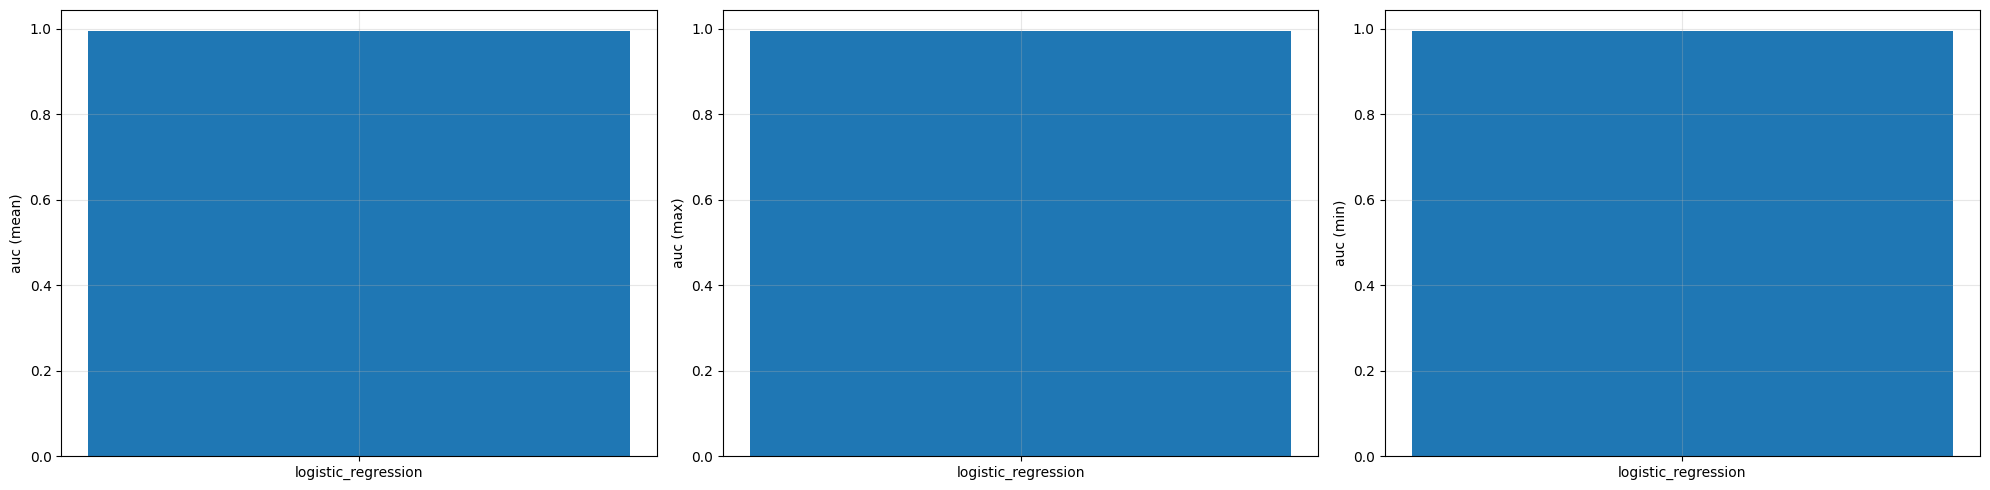

In [5]:
def plotSummary(metric):
    data = {}

    for name in df.name.unique():
        auc = df.loc[df.name == name].auc.agg(metric)
        data[name] = auc
    
    plt.bar(data.keys(), data.values())
    plt.ylabel(f'auc ({metric})')
    plt.grid(alpha=0.3)
    plt.tight_layout()


plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plotSummary('mean')

plt.subplot(1, 3, 2)
plotSummary('max')

plt.subplot(1, 3, 3)
plotSummary('min')

# SELECIONANDO MODELO

In [6]:
target = df.loc[df.name == 'logistic_regression'].sort_values(by='auc',ascending=False)
target

,accuracy,precision,recall,auc,name,id
1,0.958783,0.959367,0.958783,0.994548,logistic_regression,1
0,0.958923,0.959409,0.958923,0.994441,logistic_regression,2


In [7]:
def loadModel(id):
    with open(f'Backup/model_{id}/info.json', 'r', encoding='utf-8') as file:
        data = json.loads(file.read())

    data['model'] = joblib.load(f'Backup/model_{id}/model.pkl')
    return data


id   = target.iloc[0].id
data = loadModel(id)
data

{'model': Pipeline(steps=[('scaler', StandardScaler()), ('model', LogisticRegression())]),
 'params': {'memory': 'None',
  'steps': "[('scaler', StandardScaler()), ('model', LogisticRegression())]",
  'transform_input': 'None',
  'verbose': 'False',
  'scaler': 'StandardScaler()',
  'model': 'LogisticRegression()',
  'scaler__copy': 'True',
  'scaler__with_mean': 'True',
  'scaler__with_std': 'True',
  'model__C': '1.0',
  'model__class_weight': 'None',
  'model__dual': 'False',
  'model__fit_intercept': 'True',
  'model__intercept_scaling': '1',
  'model__l1_ratio': 'None',
  'model__max_iter': '100',
  'model__multi_class': 'deprecated',
  'model__n_jobs': 'None',
  'model__penalty': 'l2',
  'model__random_state': 'None',
  'model__solver': 'lbfgs',
  'model__tol': '0.0001',
  'model__verbose': '0',
  'model__warm_start': 'False'},
 'K_CV': 5,
 'variables': ['decayed',
  'decay',
  'min',
  'auc_recover',
  'auc',
  'mean',
  'median',
  'mean_diff',
  'auc_diff',
  'residual',
  'la

In [8]:
variables = data['variables']
model     = data['model']
model

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


# CARREGANDO DADOS

In [9]:
df = pd.read_csv('../Dataset/model.csv')
df['data'] = df.data.apply(ast.literal_eval)
df.head(3)

,decayed,decay,min,auc_recover,auc,mean,median,mean_diff,auc_diff,residual,...,max_diff,first_diff,first,slope_ratio,std_diff,time_peak,time_low,median_diff,alcohol,data
0,False,284,23250,861558,1107213,23557.723404,23281.0,-0.382979,-18.0,-259,...,1341.0,479.0,23534,-0.339346,334.276298,2,34,-2.0,False,"[23534, 24013, 26216, 26172, 26108, 25037, 240..."
1,False,261,23536,872380,1122240,23877.446809,23585.0,-0.361702,-17.0,-201,...,1168.5,367.0,23797,-0.329306,297.088420,3,37,0.5,False,"[23797, 24164, 26134, 26143, 26142, 26120, 253..."
2,False,204,23695,878804,1130612,24055.574468,23765.0,8.680851,408.0,-98,...,1175.0,1006.0,23899,-0.323574,312.737500,3,32,2.0,False,"[23899, 24905, 26249, 26359, 26335, 26225, 254..."


In [10]:
data['thresholds']

[{'class': False, 'treshold': 0.4904492733},
 {'class': True, 'treshold': 0.5122223891}]

In [11]:
model.classes_

array([False,  True])

In [12]:
variables = data['variables']
yProba    = model.predict_proba(df[variables])[:, 1]
threshold = data['thresholds'][1]['treshold']

df['result'] = np.where(yProba > threshold, model.classes_[1], model.classes_[0])
df[['result', 'alcohol']].head(10)

,result,alcohol
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
5,False,False
6,False,False
7,False,False
8,False,False
9,False,False


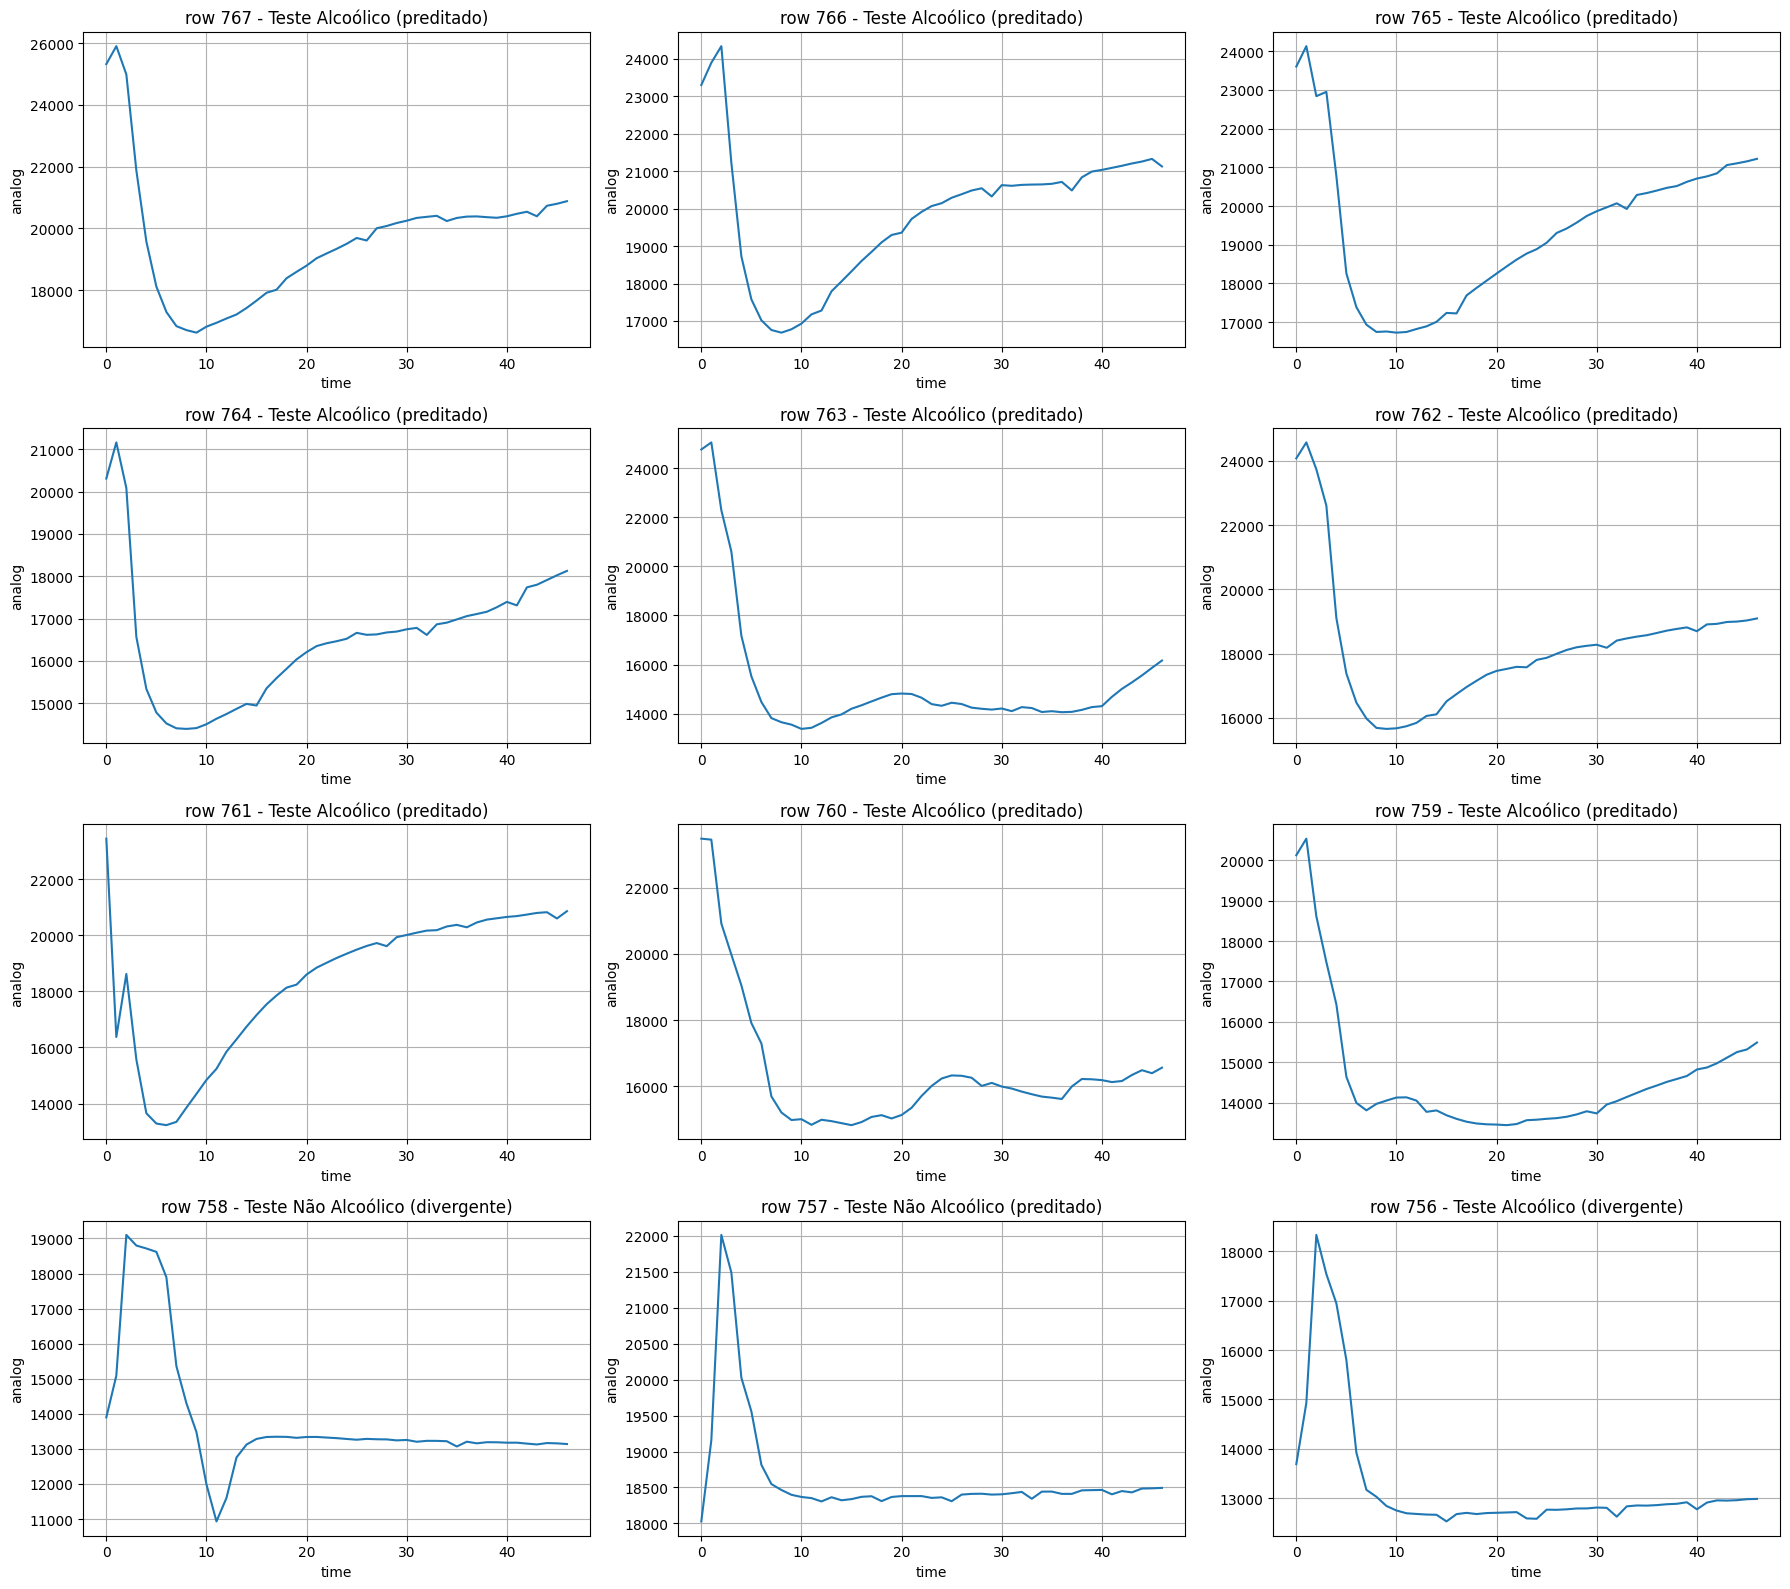

In [13]:
def plotTables(df, limit=None):
    count = len(df) if limit is None else min(limit, len(df))
    numCols = 3 if count >= 3 else count
    numRows = math.ceil(count / numCols)
    plt.figure(figsize=(6*numCols, 4*numRows))

    for idx, (i, row) in enumerate(df.iterrows()):
        if idx >= count:
            break

        plt.subplot(numRows, numCols, idx + 1)
        plt.plot(row.data)
        title  = f'row {i+2} - Teste {"Alcoólico" if row["alcohol"] else "Não Alcoólico"}'
        status = f'({"preditado" if row.alcohol == row.result else "divergente"})'
        
        plt.title(f'{title} {status}')
        plt.grid(), plt.xlabel('time'), plt.ylabel('analog')

    plt.tight_layout()
    plt.show()


plotTables(df.iloc[::-1], limit=12)

28 dados divergentes


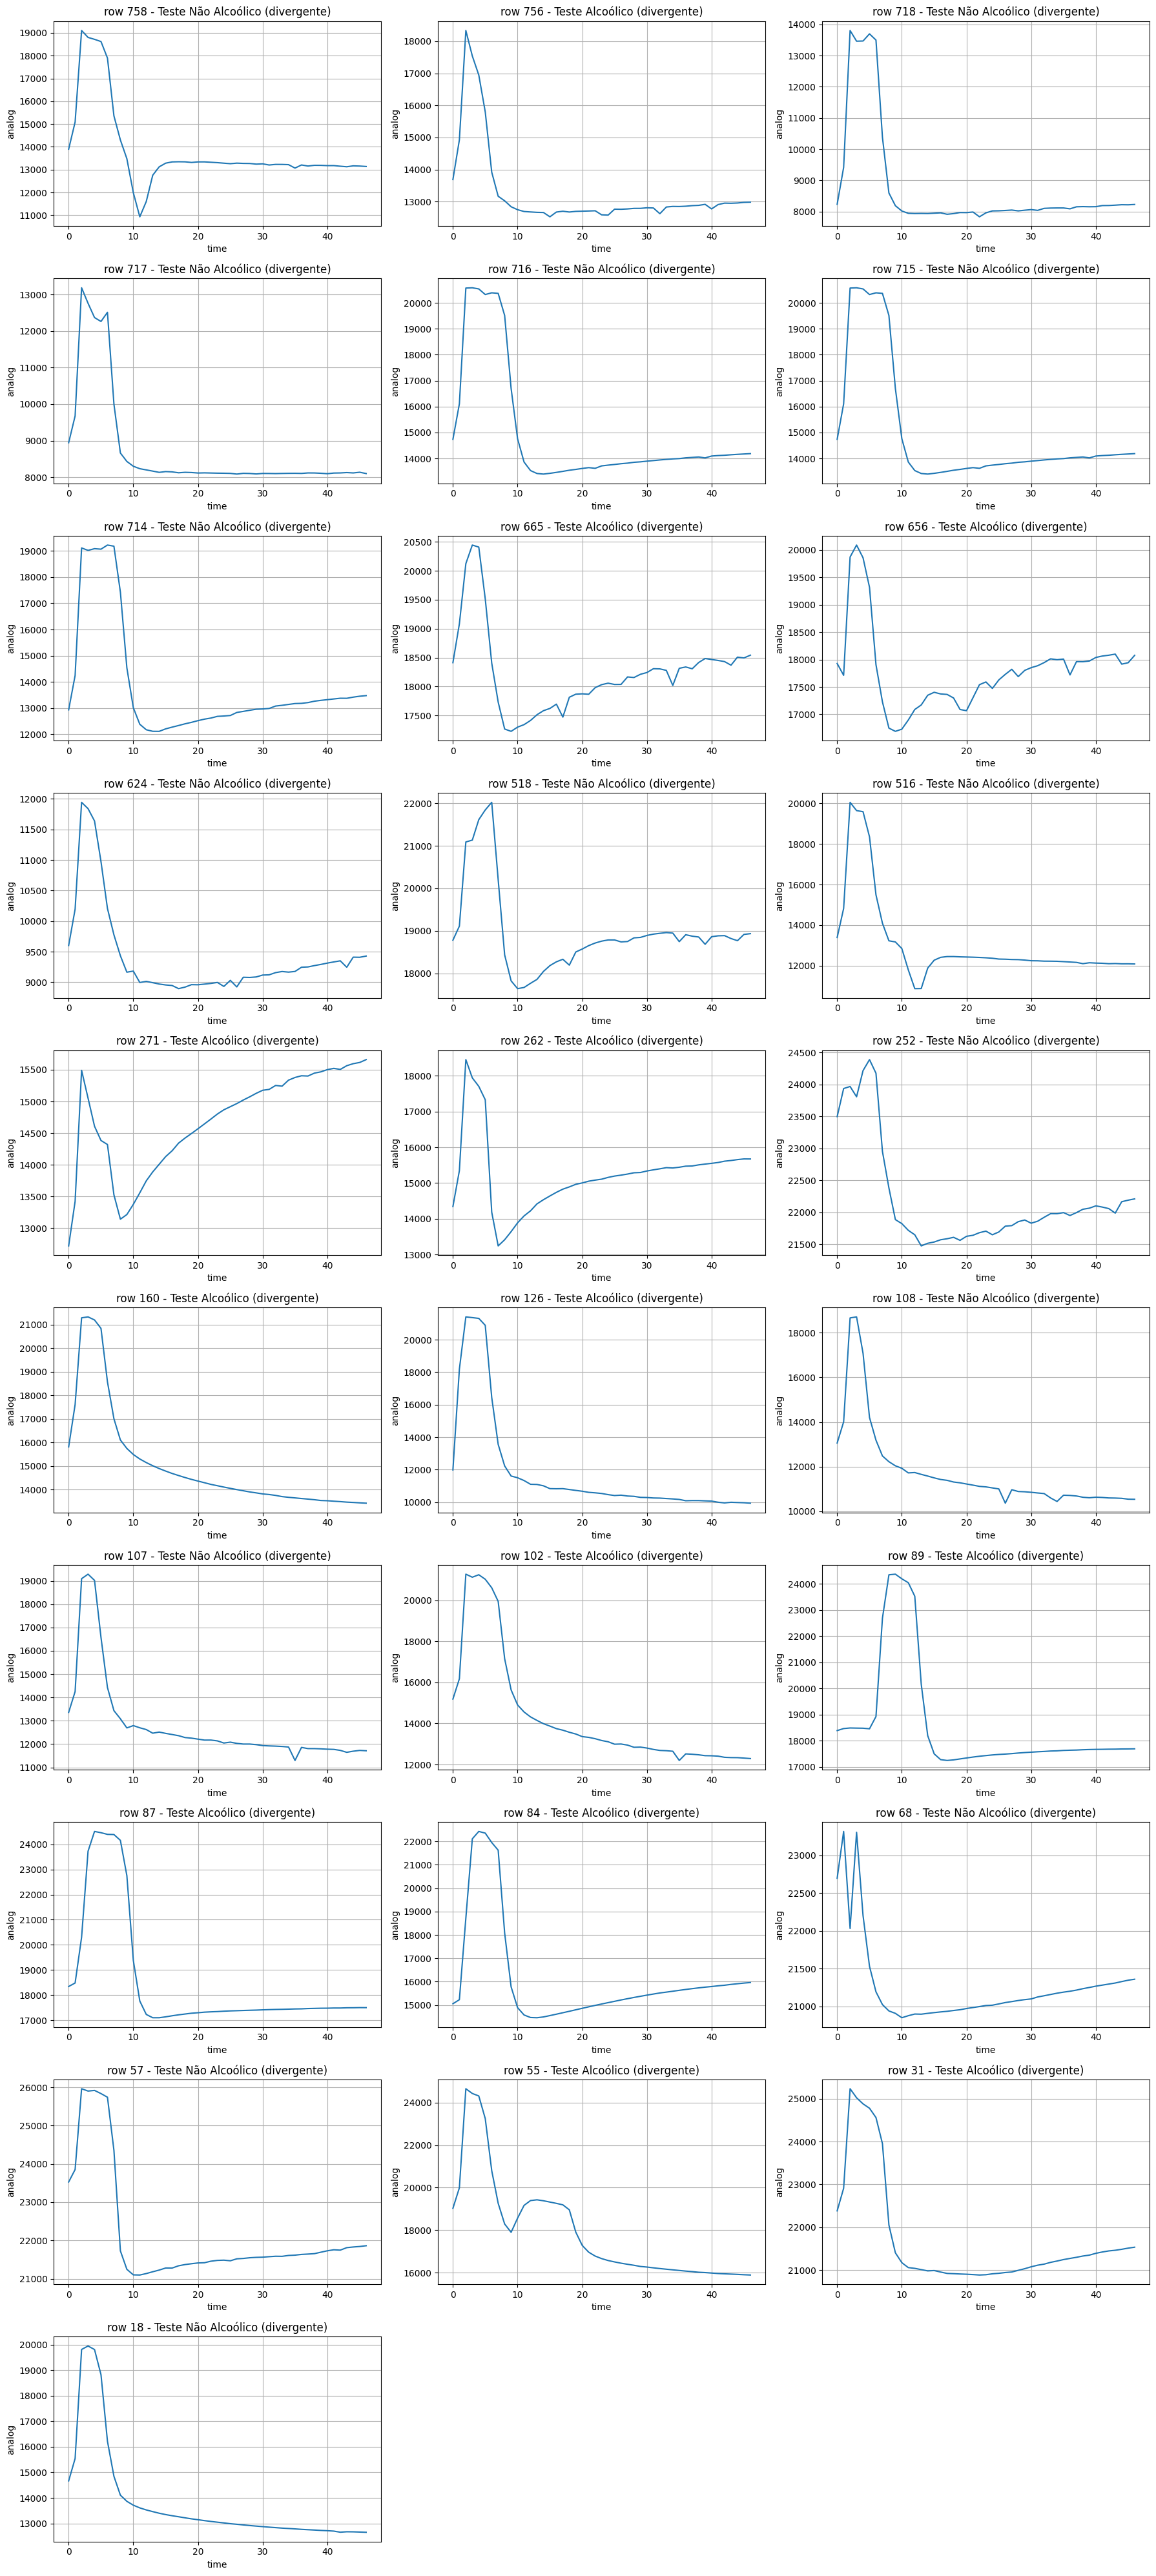

In [14]:
target = df.loc[df.alcohol != df.result].iloc[::-1]
print(f'{len(target)} dados divergentes')

if len(target) > 0:
    plotTables(target, limit=None)

# SISTEMA EMBARCADO

In [15]:
from pyperclip import copy

In [16]:
print(', '.join(variables) + ';')

decayed, decay, min, auc_recover, auc, mean, median, mean_diff, auc_diff, residual, last, reldecay, amplitude, std, max, min_diff, rise, max_diff, first_diff, first, slope_ratio, std_diff, time_peak, time_low, median_diff;


In [17]:
scaler    = model.named_steps.get('scaler')
predictor = model.named_steps.get('model')

OFFSET  = scaler.mean_
GAIN    = 1.0 / scaler.scale_
WEIGHTS = predictor.coef_[0]
BIAS    = float(predictor.intercept_[0])

In [18]:
text = f"""
bool get(){{
    static const int size     = {len(OFFSET)};
    const float OFFSET[size]  = {{ {", ".join(map(str, OFFSET))} }};
    const float GAIN[size]    = {{ {", ".join(map(str, GAIN))}   }};
    const float WEIGHTS[size] = {{ {", ".join(map(str, predictor.coef_[0]))} }};
    const float BIAS       = {str(BIAS)};
    const float BEST_TRESH = {str(threshold)};

    float z = BIAS;
    float x[size];
    int index = 0;

"""

for i, column in enumerate(variables):
    text += f'    x[index++] = (float) {column};\n'

text += """
    for(int i=0; i<size; i++)
        z += WEIGHTS[i] * (x[i] - OFFSET[i]) * GAIN[i];

    const float prob = 1.0f / (1.0f + expf(-z));
    return (prob > BEST_TRESH);
}
"""

print(text)
copy(text)


bool get(){
    static const int size     = 25;
    const float OFFSET[size]  = { 0.49216710182767626, 2943.317232375979, 15127.872062663186, 593414.0248041776, 775758.3263707572, 16505.49630576079, 16099.406005221932, -33.82842619854453, -1589.9360313315926, -1830.7650130548302, 16240.424281984335, 0.42471514407725675, 5753.518276762402, 1426.5957059372708, 20881.390339425587, -1710.007180156658, -2810.201044386423, 1428.539817232376, 468.6357702349869, 18071.189295039163, -0.2958708358397357, 489.1544864646627, 3.674934725848564, 17.219321148825067, 8.31462140992167 };
    const float GAIN[size]    = { 2.0002454623565447, 0.00027868170247420757, 0.00018789520177472653, 5.208699578713175e-06, 4.256993857863112e-06, 0.00020007871131956628, 0.00019256110365145564, 0.01177608946613981, 0.0002505550950242513, 0.0002781574802800006, 0.00018970558478148496, 2.7864313878465636, 0.0003169801603921674, 0.0011375198440154075, 0.00023725082715199452, 0.0007768195755896426, 0.0004497768704597242